# Lesson 7

## Purpose

The goal of this Lesson is to look at more advanced features of the matching software

* Multiple experiments
* Multiple score
* Scores that apply to only a subset of the data
* Fractionation
* Multiple components
* Per-component parameters

## Load CADETSettings

This imports all the standard libraries, finds CADET and find and creates all the lesson folders.

In [1]:
%run CADETSettings.ipynb

CADET was found. Continue to the next step.


# Scoring on part of a chromatogram
Sometimes there is noise in your system or some other peak in your system that you know the cause of but you don't want the matching system to look at. You could even have a high molecular weight species that you don't want to model. For these cases you can apply the score to just a section of the chromatogram.

I am making a copy of our existing dextran example from Lesson 1 and then adding a small peak to it before the main peak and then we will look at how the fitting works.

CompletedProcess(args=['C:/Users/kosh_000/CADET/cadet/bin/cadet-cli.exe', 'C:/Users/kosh_000/CADET/lessons/lesson_7/example_0/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


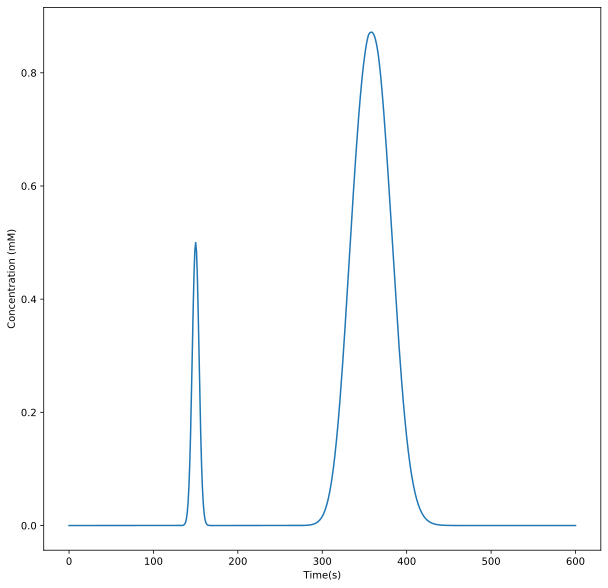

In [2]:
example_dir_0 = lesson_7 / "example_0"
example_dir_0.mkdir(exist_ok = True)

example0 = Cadet()

#give a filename for where the simulation should be saved
example0.filename = (lesson_1 / "example_0" / 'example.h5').as_posix()

example0.load()

example0.filename = (example_dir_0 / 'example.h5').as_posix()

#save the simulation
example0.save()

#run the simulation
data = example0.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    example0.load()
    
    times = example0.root.output.solution.solution_times
    values = example0.root.output.solution.unit_002.solution_outlet_comp_000
    
    #add a small peak to values between 100 and 200 seconds
    
    selected = (times >= 100) & (times <= 200)
    values[selected] = scipy.signal.gaussian(101, 4) * 0.5
    
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(times, values)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([times,
                        values]).transpose()
    data.to_csv((example_dir_0 / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Look at the simple match
We will first use the example from Lesson 4 to match this data set without any slicing and see what happens

In [3]:
match0 = Dict()
match0.CADETPath = cadet_path.as_posix()
match0.baseDir = example_dir_0.as_posix()
match0.resultsDir = 'fit_nsga3'
match0.csv = 'fit_results.csv'
match0.gradVector = 0
match0.searchMethod = 'NSGA3'
match0.population = 12
match0.finalGradRefinement = 0
match0.stallGenerations = 10

parameter1 = Dict()
parameter1.transform = 'norm_log'
parameter1.component = -1
parameter1.bound = -1
parameter1.location = "/input/model/unit_001/COL_DISPERSION"
parameter1.min = 1e-10
parameter1.max = 1e-6

parameter2 = Dict()
parameter2.transform = 'norm'
parameter2.component = -1
parameter2.bound = -1
parameter2.location = "/input/model/unit_001/COL_POROSITY"
parameter2.min = 0.2
parameter2.max = 0.5

match0.parameters = [parameter1, parameter2]

experiment1 = Dict()
experiment1.csv = "example.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'DextranShape'

experiment1.features = [feature1,]

match0.experiments = [experiment1,]

match_file0 = example_dir_0 / 'example_nsga3_simple.json'

with (match_file0).open('w') as json_file:
    json.dump(match0.to_dict(), json_file, indent='\t')

## Run parameter estimation on the full chromatogram

Your results are located at C:/Users/kosh_000/CADET/lessons/lesson_7/example_0/fit_nsga3 


[2019-10-16 16:19:41,493] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-16 16:19:41,493] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-16 16:19:41,493] launcher  INFO    Worker distribution: 

[2019-10-16 16:19:41,493] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-16 16:19:44,512] util      (b'127.0.0.1:53582') INFO    example.h5 abstol=3.03e-05  reltol=0.0001

[2019-10-16 16:19:44,664] match     (b'127.0.0.1:53582') INFO    simulation took 0.15199923515319824

[2019-10-16 16:19:44,928] gradFD    (b'127.0.0.1:53582') INFO    grad simulation took 0.23200178146362305

[2019-10-16 16:19:44,928] gradFD    (b'127.0.0.1:53582') INFO    grad C:/Users/kosh_000/CADET/lessons/lesson_7/example_0/fit_nsga3/misc/template_main_grad.h5 abstol=3.03e-09  reltol=

[2019-10-16 16:20:48,105] launcher  (127.0.0.1:60730) INFO    Root process is done.

[2019-10-16 16:20:48,105] launcher  (127.0.0.1:60730) INFO    Finished cleaning spawned subprocesses.

Best item 81e3fbc59c11153b2777a92fc081cc5c for meta score(s) Product Root Score , Mean Score


,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Shape,main_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
47,Wed Oct 16 16:20:02 2019,81e3fbc59c11153b2777a92fc081cc5c,EVO,NaN,3.692309e-08,0.200001,0.999405,0.929517,0.963828,0.929517,0.964461,0.384104


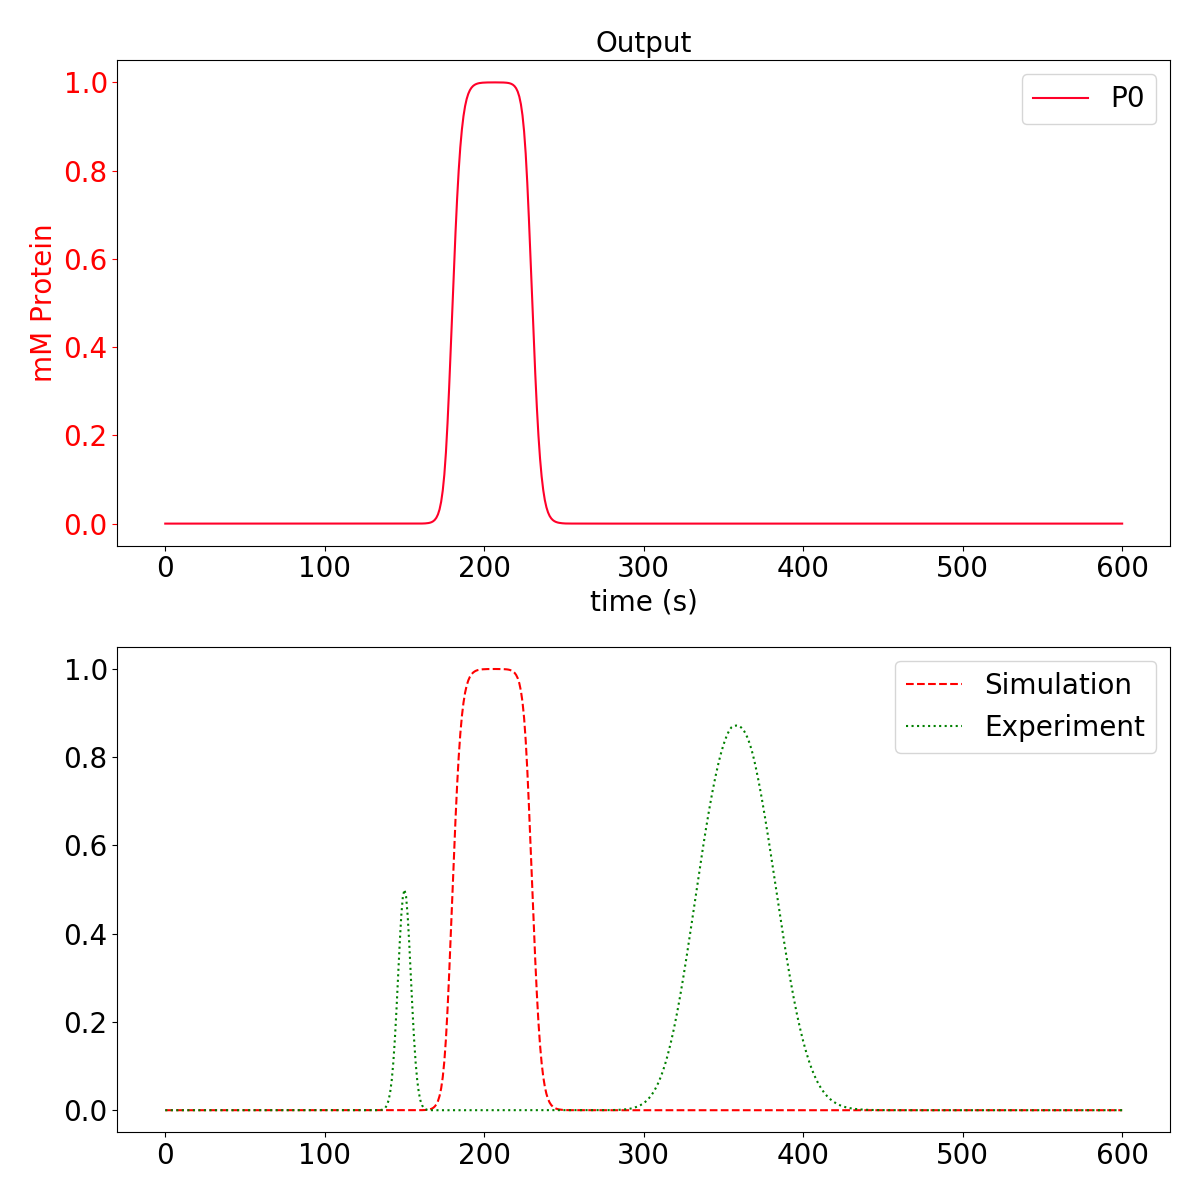

,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Shape,main_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
64,Wed Oct 16 16:20:05 2019,2c066eb42fa4a01891537373104532d6,EVO,NaN,7.103204e-07,0.200003,0.937764,0.938777,0.93827,0.937764,0.93827,0.60578


Best item 2c066eb42fa4a01891537373104532d6 for meta score(s) Min Score


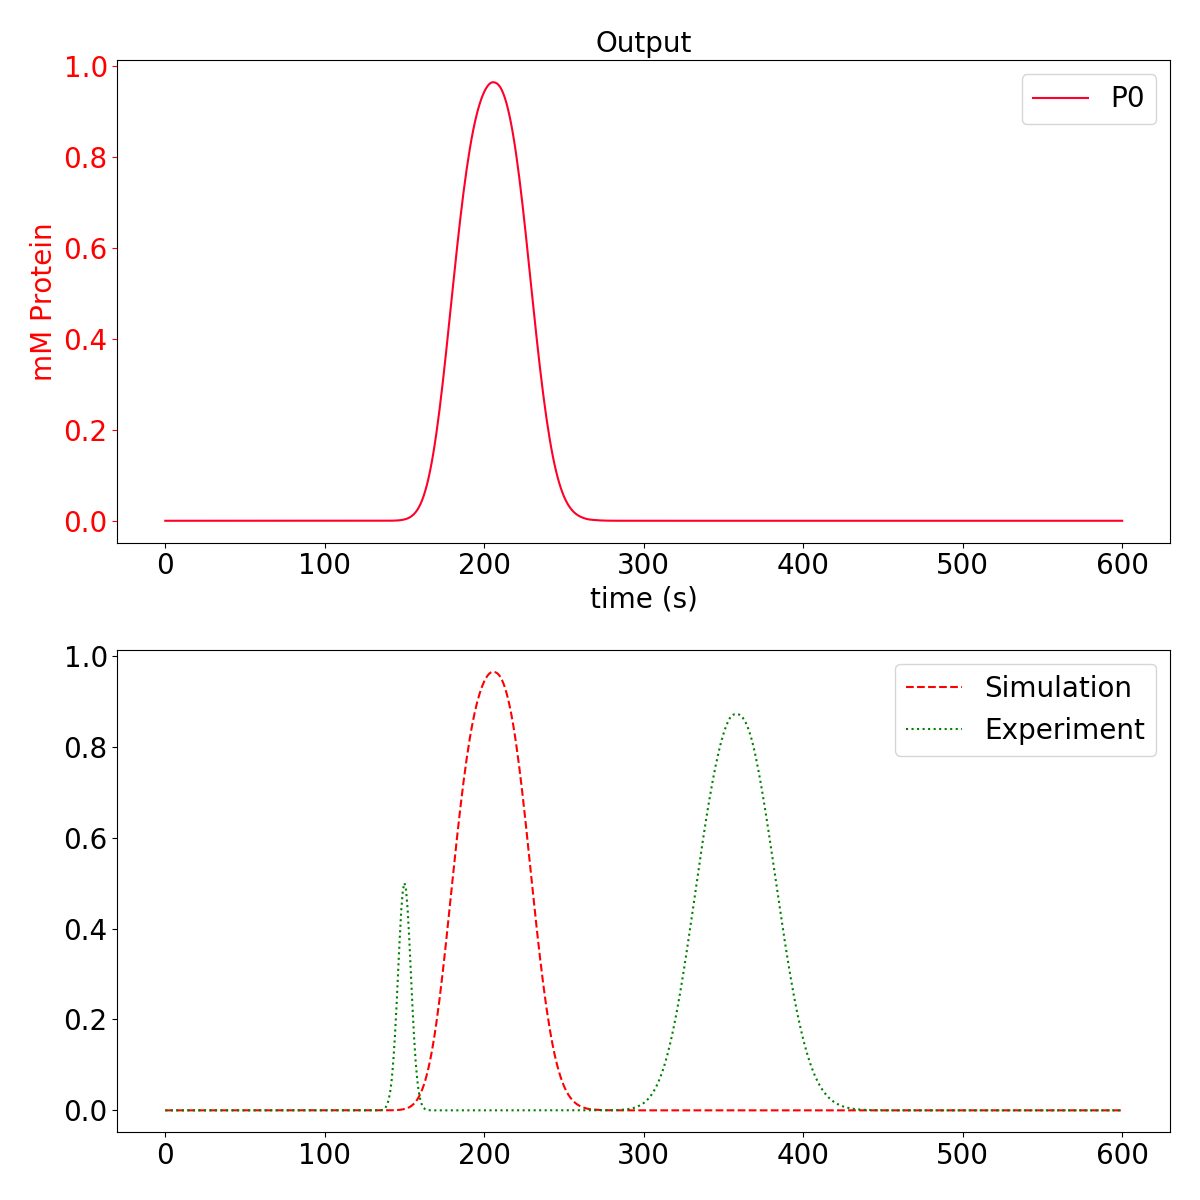

Best item 6d9e568dd8b6542f697cba3026109bc6 for meta score(s) SSE


,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Shape,main_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
77,Wed Oct 16 16:20:07 2019,6d9e568dd8b6542f697cba3026109bc6,EVO,NaN,6.280867e-07,0.200032,0.940669,0.936568,0.938617,0.936568,0.938619,0.653842


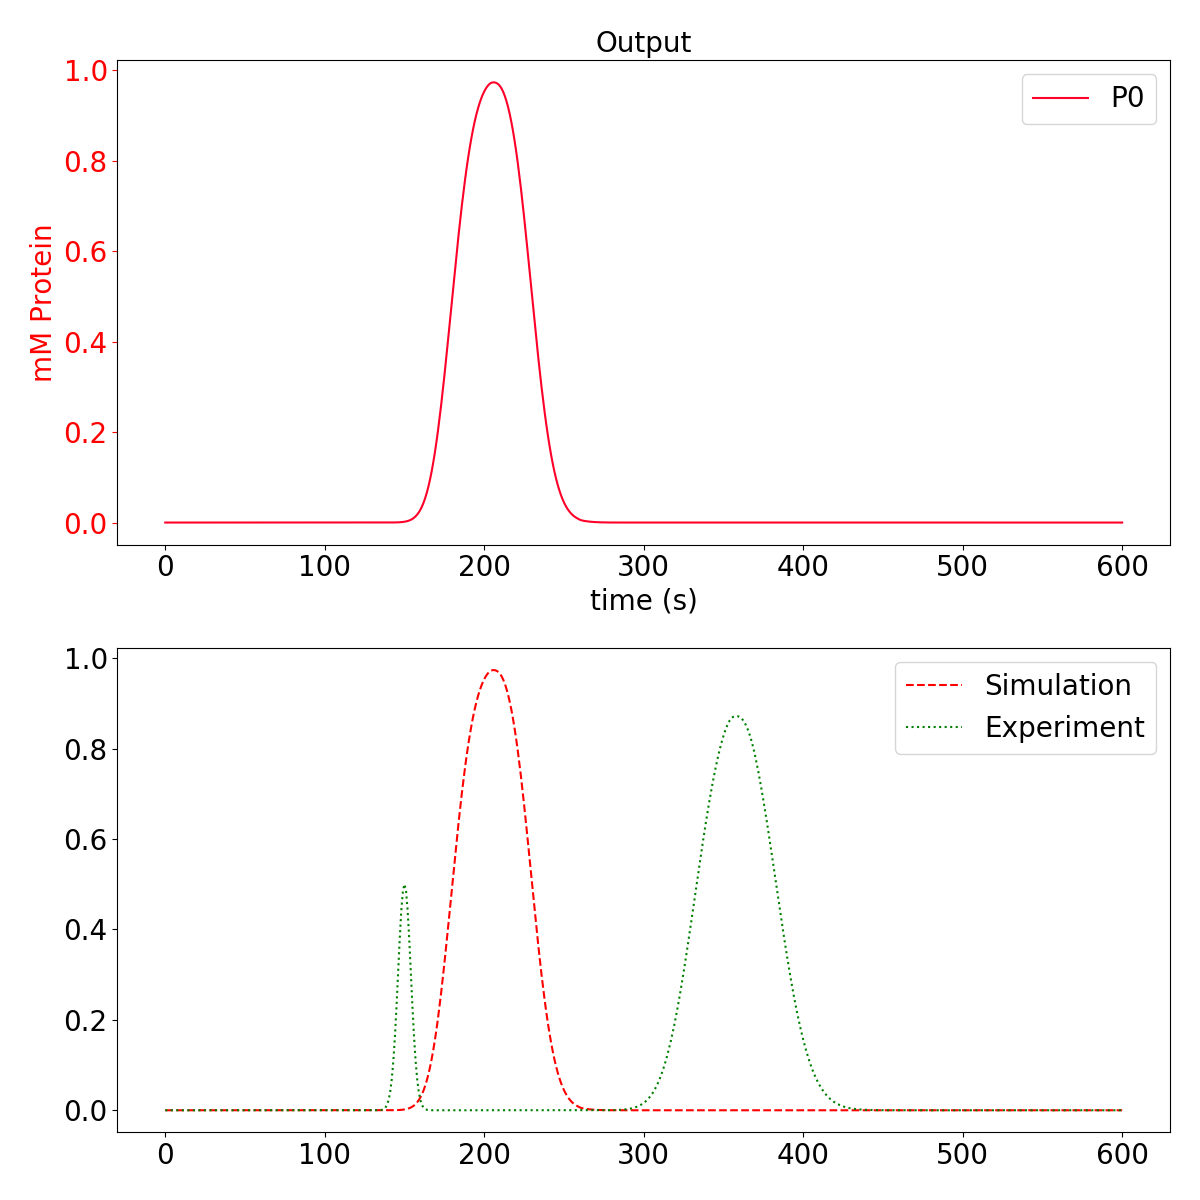

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 3.69e-08  true_value = 2.00e-07 error: 4.4e+02%
COL_POROSITY Comp:-1 Bound:-1 = 2.00e-01  true_value = 3.70e-01 error: 85%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 7.10e-07  true_value = 2.00e-07 error: 72%
COL_POROSITY Comp:-1 Bound:-1 = 2.00e-01  true_value = 3.70e-01 error: 85%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 3.69e-08  true_value = 2.00e-07 error: 4.4e+02%
COL_POROSITY Comp:-1 Bound:-1 = 2.00e-01  true_value = 3.70e-01 error: 85%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 6.28e-07  true_value = 2.00e-07 error: 68%
COL_POROSITY Comp:-1 Bound:-1 = 2.00e-01  true_value = 3.70e-01 error: 85%




In [4]:
true_values0 = numpy.array([example0.root.input.model.unit_001.col_dispersion, 
                           example0.root.input.model.unit_001.col_porosity])
    
sim0 = run_match(match0,
                    match_file0,
                    true_values0,
                    delete=True)

## Create a configuration file for a slice

Features inside experiments take an optional start and stop argument. If you provide start and stop the score will only apply inside that region.

```json
{
  "name": "Pulse",
  "type": "DextranShape"
}```

```python
feature = Dict()
feature.name = "Pulse"
feature.type = "DextranShape"``` 

Gets changed to

```json
{
  "name": "Pulse",
  "type": "DextranShape"
  "start": 250,
  "stop": 450
}```

```python
feature = Dict()
feature.name = "Pulse"
feature.type = "DextranShape"
feature.start = 250
feature.stop = 450``` 

In [9]:
match0_slice = Dict(match0.copy())
match0_slice.CADETPath = cadet_path.as_posix()
match0_slice.baseDir = example_dir_0.as_posix()
match0_slice.resultsDir = 'fit_nsga3_slice'
match0_slice.gradVector = 0
match0_slice.finalGradRefinement = 0

experiment1 = Dict()
experiment1.csv = "example.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'DextranShape'
feature1.start = 250
feature1.stop = 450

experiment1.features = [feature1,]

match0_slice.experiments = [experiment1,]

match_file0_slice = example_dir_0 / 'example_nsga3_slice.json'

with (match_file0_slice).open('w') as json_file:
    json.dump(match0_slice.to_dict(), json_file, indent='\t')

## Run parameter estimation on a slice

Your results are located at C:/Users/kosh_000/CADET/lessons/lesson_7/example_0/fit_nsga3_slice 


[2019-10-16 16:23:23,929] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-16 16:23:23,929] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-16 16:23:23,929] launcher  INFO    Worker distribution: 

[2019-10-16 16:23:23,929] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-16 16:23:26,664] util      (b'127.0.0.1:49338') INFO    example.h5 abstol=4.71e-05  reltol=0.0001

[2019-10-16 16:23:26,803] match     (b'127.0.0.1:49338') INFO    simulation took 0.13800477981567383

[2019-10-16 16:23:27,044] gradFD    (b'127.0.0.1:49338') INFO    grad simulation took 0.21202349662780762

[2019-10-16 16:23:27,044] gradFD    (b'127.0.0.1:49338') INFO    grad C:/Users/kosh_000/CADET/lessons/lesson_7/example_0/fit_nsga3_slice/misc/template_main_grad.h5 abstol=4.71e

[2019-10-16 16:23:58,493] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-16 16:23:58,493] launcher  INFO    Deploying 1 worker(s) over 1 host(s).

[2019-10-16 16:23:58,493] launcher  INFO    Worker distribution: 

[2019-10-16 16:23:58,493] launcher  INFO       127.0.0.1:	0 + origin

[2019-10-16 16:24:00,473] generate_corner_graphs (b'127.0.0.1:65123') INFO    graphing directory C:\Users\kosh_000\CADET\lessons\lesson_7\example_0

[2019-10-16 16:24:00,473] generate_corner_graphs (b'127.0.0.1:65123') INFO    plotting corner plots

[2019-10-16 16:24:00,478] generate_corner_graphs (b'127.0.0.1:65123') INFO    graphing remove 0 points

[2019-10-16 16:24:14,997] launcher  (127.0.0.1:63791) INFO    Root process is done.

[2019-10-16 16:24:14,998] launcher  (127.0.0.1:63791) INFO    Finished cleaning spawned subprocesses.

[2019-10-16 16:24:15,011] match     (b'127.0.0.1:49

,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Shape,main_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
0,Wed Oct 16 16:23:47 2019,60f603f9154c867aee5a2efc7ea5187b,EVO,NaN,1.962758e-07,0.369713,0.999999,0.999995,0.999997,0.999995,0.999997,0.00029


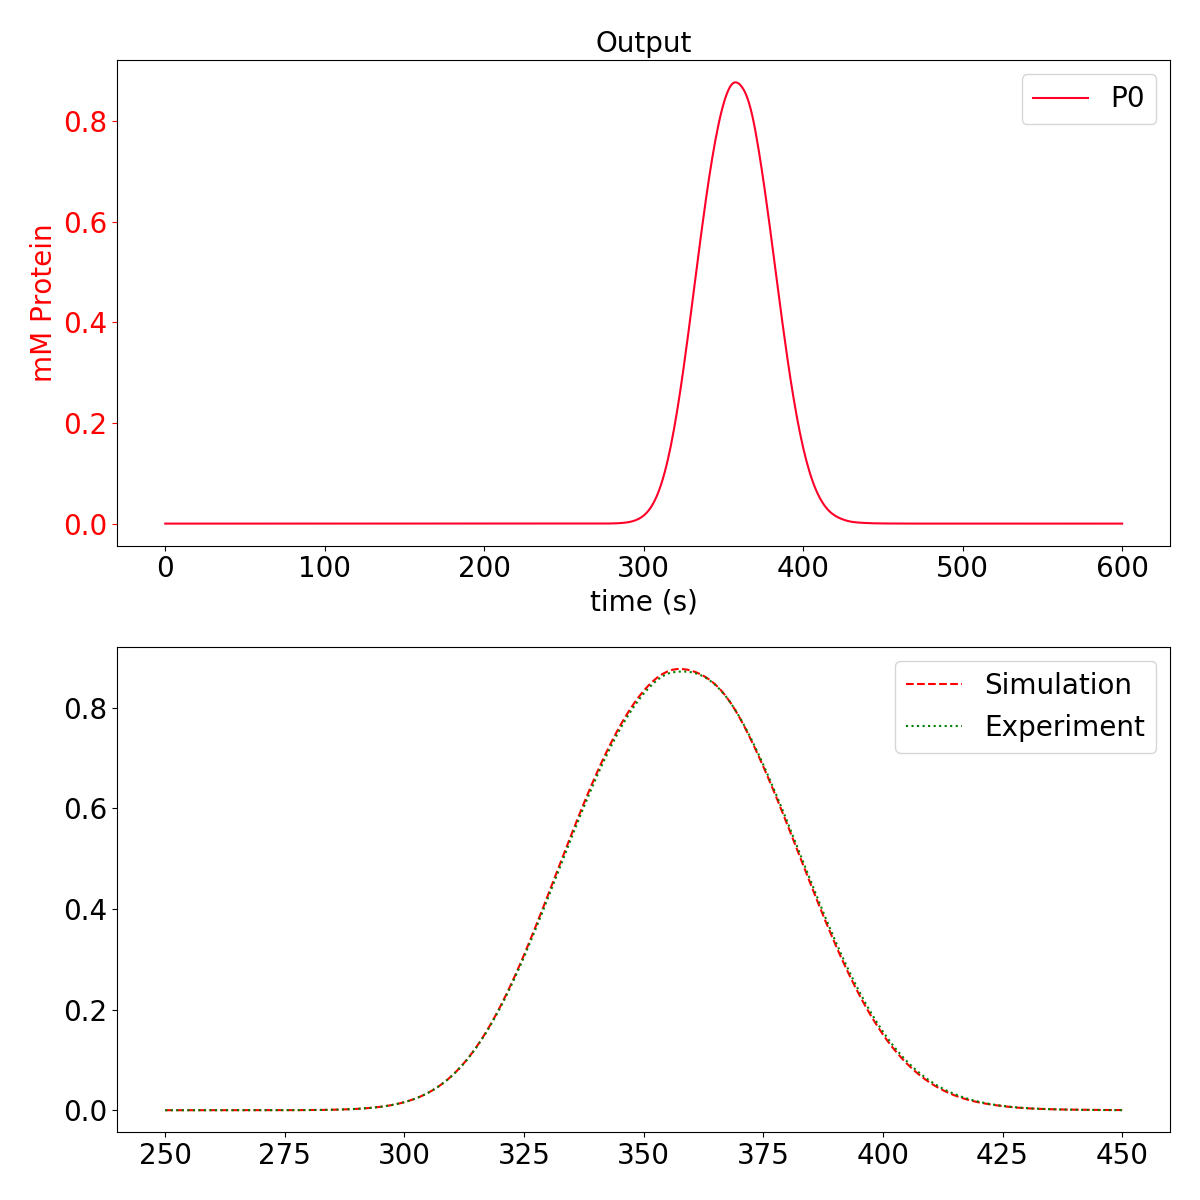

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.96e-07  true_value = 2.00e-07 error: 1.9%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 0.078%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.96e-07  true_value = 2.00e-07 error: 1.9%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 0.078%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.96e-07  true_value = 2.00e-07 error: 1.9%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 0.078%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 1.96e-07  true_value = 2.00e-07 error: 1.9%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 0.078%




In [10]:
true_values0_slice = numpy.array([example0.root.input.model.unit_001.col_dispersion, 
                           example0.root.input.model.unit_001.col_porosity])
    
sim_slice = run_match(match0_slice,
                    match_file0_slice,
                    true_values0_slice,
                    delete=True)

# Multiple experiments
As the model becomes more complex it can require multiple experiments in order to obtain a unique answer. For fitting the Steric-Mass-Action isotherm usually 2-3 gradients + breakthrough is necessary. Multiple experiments are also useful when you have errors in your system

In this case we will create another variant of the Dextran pulse for fitting. For the purposes of the workshop we will just change the length of the column.

CompletedProcess(args=['C:/Users/kosh_000/CADET/cadet/bin/cadet-cli.exe', 'C:/Users/kosh_000/CADET/lessons/lesson_7/multiple_experiments/example_1.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully
CompletedProcess(args=['C:/Users/kosh_000/CADET/cadet/bin/cadet-cli.exe', 'C:/Users/kosh_000/CADET/lessons/lesson_7/multiple_experiments/example_2.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


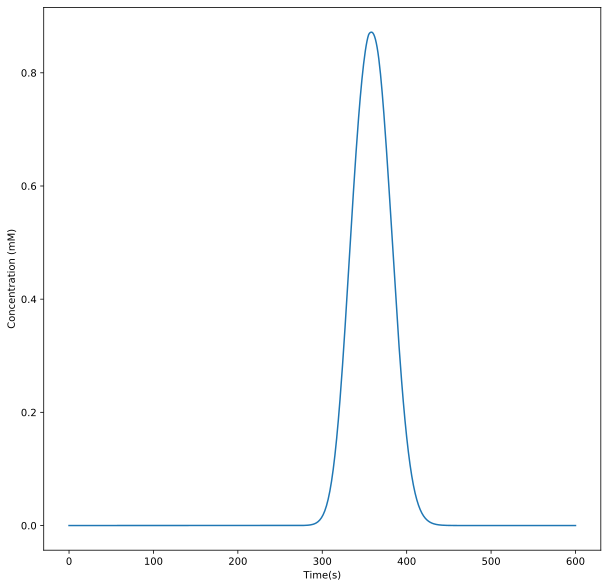

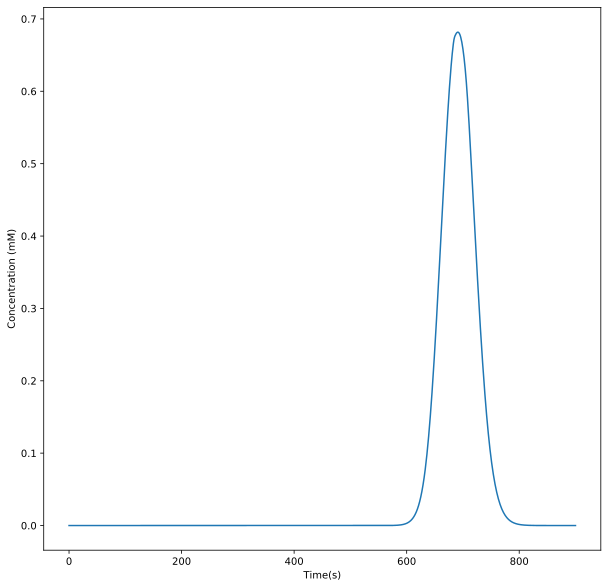

In [11]:
example_dir_1 = lesson_7 / "multiple_experiments"
example_dir_1.mkdir(exist_ok = True)

example1a = Cadet()

#give a filename for where the simulation should be saved
example1a.filename = (lesson_1 / "example_0" / 'example.h5').as_posix()

example1a.load()

example1a.filename = (example_dir_1 / 'example_1.h5').as_posix()

#save the simulation
example1a.save()

#run the simulation
data = example1a.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    example1a.load()
    
    times = example1a.root.output.solution.solution_times
    values = example1a.root.output.solution.unit_002.solution_outlet_comp_000
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(times, values)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([times, values]).transpose()
    data.to_csv((example_dir_1 / 'example_1.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")
    
    
    
example1b = Cadet()

#give a filename for where the simulation should be saved
example1b.filename = (lesson_1 / "example_0" / 'example.h5').as_posix()

example1b.load()

example1b.filename = (example_dir_1 / 'example_2.h5').as_posix()

example1b.root.input.model.unit_001.col_length = example1a.root.input.model.unit_001.col_length * 2
example1b.root.input.solver.sections.section_times = [0.0, 50.0, 900.0]
example1b.root.input.solver.user_solution_times = numpy.linspace(0, 900, 901)

#save the simulation
example1b.save()

#run the simulation
data = example1b.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    example1b.load()
    
    times = example1b.root.output.solution.solution_times
    values = example1b.root.output.solution.unit_002.solution_outlet_comp_000
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(times, values)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([times, values]).transpose()
    data.to_csv((example_dir_1 / 'example_2.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Create a configuration file

We are estimating one set of parameters for two experiments. Most of the file stays exactly the same and we just have to add two experiments.

The only thing we need to do is add another experiment and we can use the same score for this new experiment as the first experiment.

In [13]:
match1 = Dict(match0.copy())
match1.CADETPath = cadet_path.as_posix()
match1.baseDir = example_dir_1.as_posix()
match1.resultsDir = 'fit_nsga3_multiple'

experiment1 = Dict()
experiment1.csv = "example_1.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example_1.h5"
experiment1.name = "exp1"
experiment1.timeout = 30.0

experiment2 = Dict()
experiment2.csv = "example_2.csv"
experiment2.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment2.HDF5 = "example_2.h5"
experiment2.name = "exp2"
experiment2.timeout = 30.0

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'DextranShape'

experiment1.features = [feature1,]

experiment2.features = [feature1,]

match1.experiments = [experiment1, experiment2]

match_file1 = example_dir_1 / 'example_nsga3_multiple.json'

with (match_file1).open('w') as json_file:
    json.dump(match1.to_dict(), json_file, indent='\t')

## Run parameter estimation
Now that we have our new experimental setup we can run the matching process.

Your results are located at C:/Users/kosh_000/CADET/lessons/lesson_7/multiple_experiments/fit_nsga3_multiple 


[2019-10-16 16:26:17,952] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-16 16:26:17,952] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-16 16:26:17,952] launcher  INFO    Worker distribution: 

[2019-10-16 16:26:17,952] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-16 16:26:20,971] util      (b'127.0.0.1:60718') INFO    example_1.h5 abstol=4.71e-05  reltol=0.0001

[2019-10-16 16:26:21,106] match     (b'127.0.0.1:60718') INFO    simulation took 0.1350383758544922

[2019-10-16 16:26:21,136] util      (b'127.0.0.1:60718') INFO    example_2.h5 abstol=4.01e-05  reltol=0.0001

[2019-10-16 16:26:21,285] match     (b'127.0.0.1:60718') INFO    simulation took 0.14910626411437988

[2019-10-16 16:26:21,559] gradFD    (b'127.0.0.1:60718')

[2019-10-16 16:27:14,258] util      (b'127.0.0.1:60718') INFO    Generation: 34 	Population: 24 	Average Score: 0.992 	Best: 1 	Minimum Score: 0.985 	Best: 1 	Product Score: 0.992 	Best: 1

[2019-10-16 16:27:15,663] util      (b'127.0.0.1:60718') INFO    Generation: 35 	Population: 24 	Average Score: 0.992 	Best: 1 	Minimum Score: 0.985 	Best: 1 	Product Score: 0.992 	Best: 1

[2019-10-16 16:27:17,082] util      (b'127.0.0.1:60718') INFO    Generation: 36 	Population: 24 	Average Score: 0.993 	Best: 1 	Minimum Score: 0.986 	Best: 1 	Product Score: 0.993 	Best: 1

[2019-10-16 16:27:18,562] util      (b'127.0.0.1:60718') INFO    Generation: 37 	Population: 24 	Average Score: 0.993 	Best: 1 	Minimum Score: 0.986 	Best: 1 	Product Score: 0.993 	Best: 1

[2019-10-16 16:27:19,988] util      (b'127.0.0.1:60718') INFO    Generation: 38 	Population: 24 	Average Score: 0.993 	Best: 1 	Minimum Score: 0.986 	Best: 1 	Product Score: 0.993 	Best: 1

[2019-10-16 16:27:21,376] util      (b'127.0.0.1:6

,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,exp1_Pulse_Shape,exp1_Pulse_Time,exp2_Pulse_Shape,exp2_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
0,Wed Oct 16 16:27:12 2019,1c1fb11211bad81012965827aafe97a2,EVO,NaN,1.933483e-07,0.369438,0.999998,0.999999,0.999999,0.999997,0.999998,0.999997,0.999998,0.003972


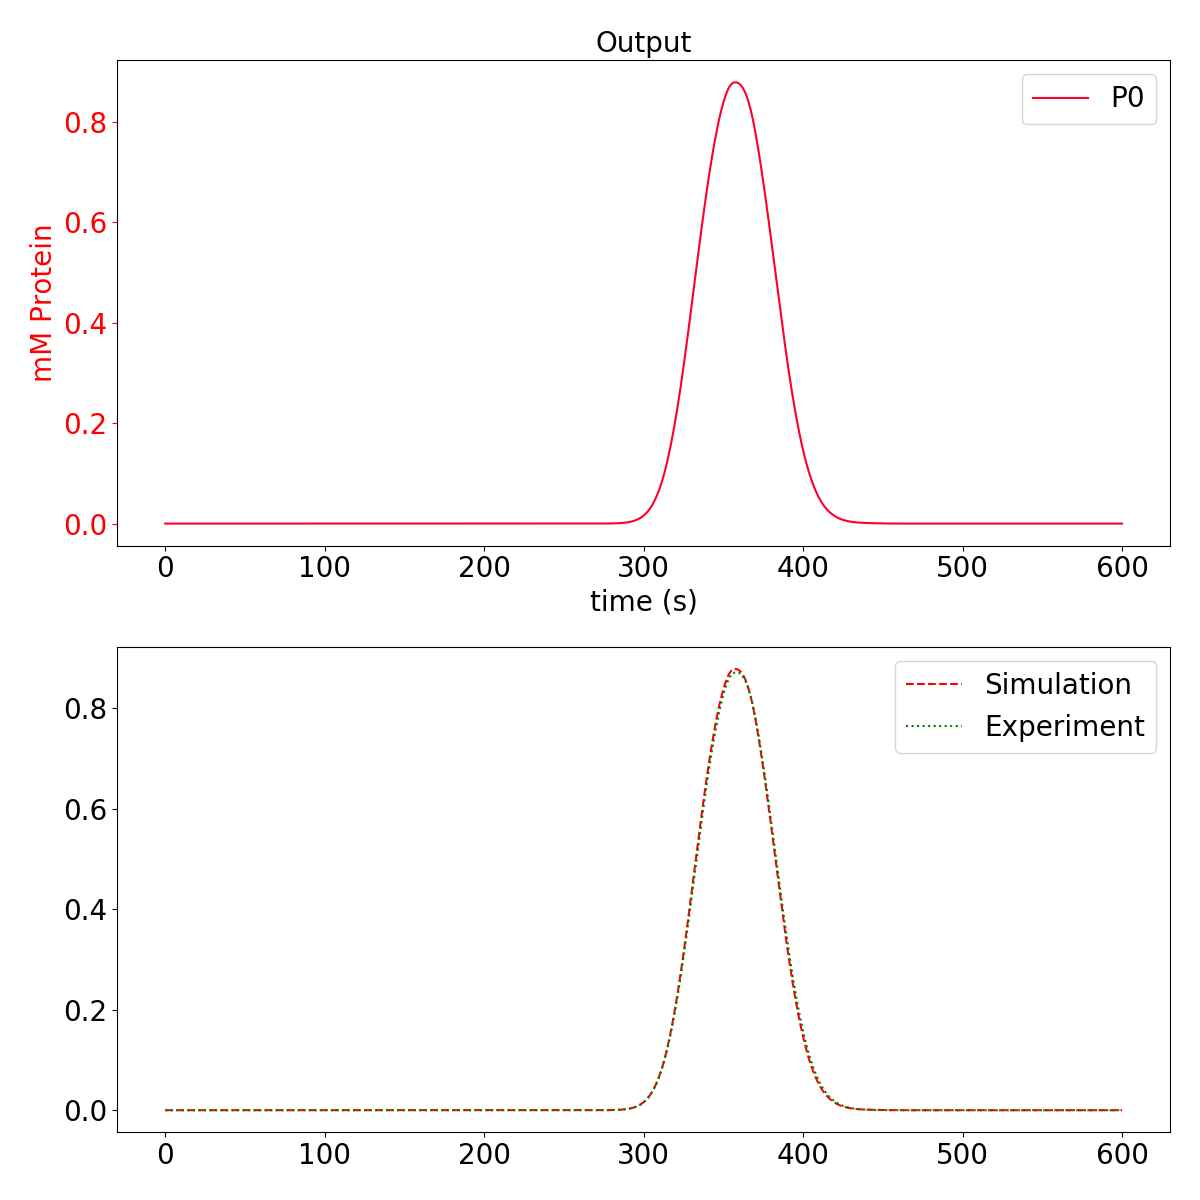

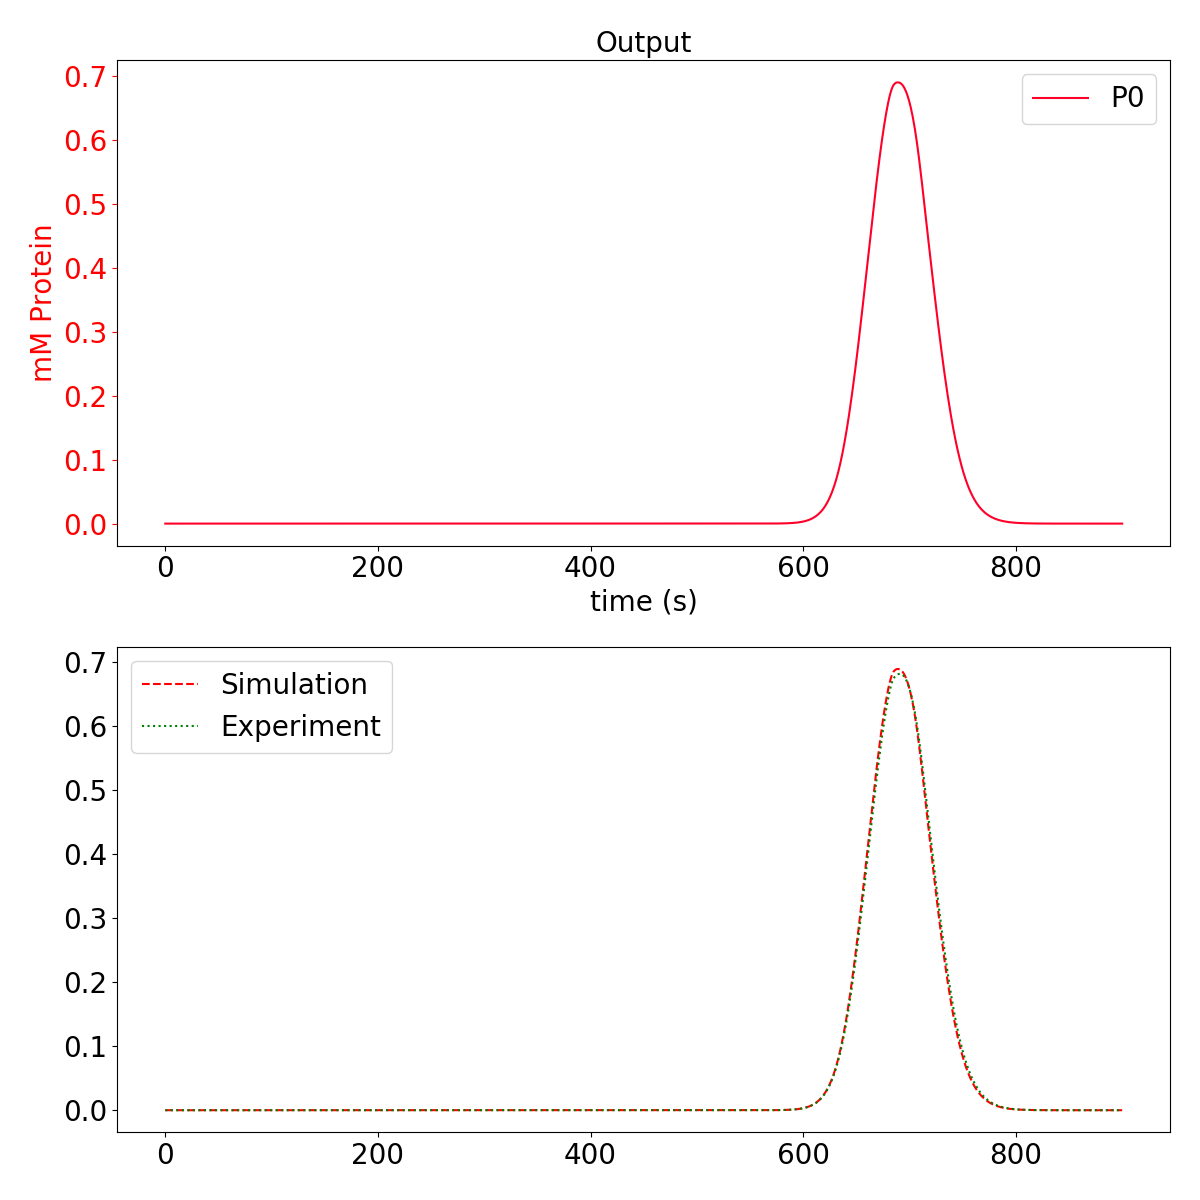

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.93e-07  true_value = 2.00e-07 error: 3.4%
COL_POROSITY Comp:-1 Bound:-1 = 3.69e-01  true_value = 3.70e-01 error: 0.15%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.93e-07  true_value = 2.00e-07 error: 3.4%
COL_POROSITY Comp:-1 Bound:-1 = 3.69e-01  true_value = 3.70e-01 error: 0.15%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.93e-07  true_value = 2.00e-07 error: 3.4%
COL_POROSITY Comp:-1 Bound:-1 = 3.69e-01  true_value = 3.70e-01 error: 0.15%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 1.93e-07  true_value = 2.00e-07 error: 3.4%
COL_POROSITY Comp:-1 Bound:-1 = 3.69e-01  true_value = 3.70e-01 error: 0.15%




In [14]:
true_values1 = numpy.array([example1a.root.input.model.unit_001.col_dispersion, 
                           example1a.root.input.model.unit_001.col_porosity])
    
sim_multiple = run_match(match1,
                    match_file1,
                    true_values1,
                    delete=True)

# Multiple components
Dealing with multiple components is only slightly more complex. For this example I will take the Dextran pulse example and add a second component to it with a different concentration. After that we will look at how to fit the system with a score for each component.

CompletedProcess(args=['C:/Users/kosh_000/CADET/cadet/bin/cadet-cli.exe', 'C:/Users/kosh_000/CADET/lessons/lesson_7/example_2/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


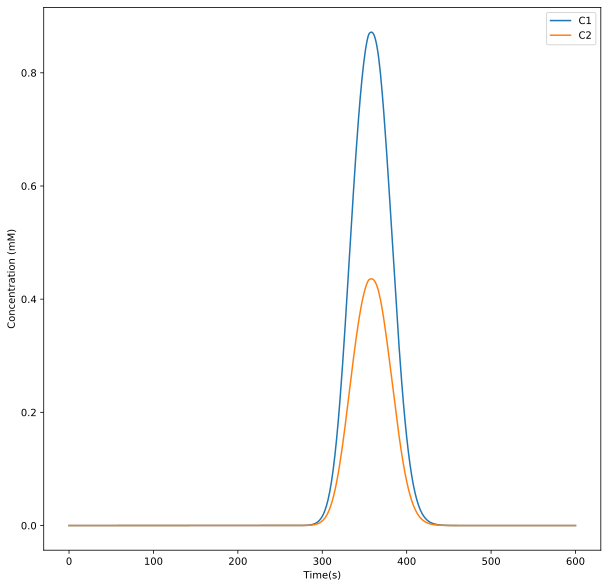

In [16]:
example_dir_2 = lesson_7 / "example_2"
example_dir_2.mkdir(exist_ok = True)

example2 = Cadet()

#give a filename for where the simulation should be saved
example2.filename = (lesson_1 / "example_0" / 'example.h5').as_posix()

example2.load()

example2.filename = (example_dir_2 / 'example.h5').as_posix()

#add a second component, many small things change with this

example2.root.input.model.unit_000.ncomp = 2

#const_coeff + lin_coeff*t + quad_coeff*t^2 + cube_coeff*t^3
example2.root.input.model.unit_000.sec_000.const_coeff = [1.0, 0.5]
example2.root.input.model.unit_000.sec_000.lin_coeff =   [0.0, 0.0]
example2.root.input.model.unit_000.sec_000.quad_coeff =  [0.0, 0.0]
example2.root.input.model.unit_000.sec_000.cube_coeff =  [0.0, 0.0]

example2.root.input.model.unit_000.sec_001.const_coeff = [0.0, 0.0]
example2.root.input.model.unit_000.sec_001.lin_coeff =   [0.0, 0.0]
example2.root.input.model.unit_000.sec_001.quad_coeff =  [0.0, 0.0]
example2.root.input.model.unit_000.sec_001.cube_coeff =  [0.0, 0.0]

example2.root.input.model.unit_002.ncomp = 2

example2.root.input.model.unit_001.ncomp = 2
example2.root.input.model.unit_001.init_c = [0.0, 0.0]
example2.root.input.model.unit_001.init_q = [0.0, 0.0]
example2.root.input.model.unit_001.film_diffusion = [0.0, 0.0]

example2.root.input.model.unit_001.discretization.nbound = [0, 0]

#save the simulation
example2.save()

#run the simulation
data = example2.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    example2.load()
    
    times = example2.root.output.solution.solution_times
    values1 = example2.root.output.solution.unit_002.solution_outlet_comp_000
    values2 = example2.root.output.solution.unit_002.solution_outlet_comp_001
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(times, values1, label='C1')
    plt.plot(times, values2, label='C2')
    plt.legend()
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    plt.show()
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([times, values1]).transpose()
    data.to_csv((example_dir_2 / 'example_c1.csv').as_posix(), index=False, header=False)
    
    data = pandas.DataFrame([times, values2]).transpose()
    data.to_csv((example_dir_2 / 'example_c2.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Create a configuration file

In this case we are matching to a single experiment with two components but using the same two input variables.

In [18]:
match2 = Dict(match0.copy())
match2.CADETPath = cadet_path.as_posix()
match2.baseDir = example_dir_2.as_posix()
match2.resultsDir = 'fit_nsga3_comps'

experiment1 = Dict()
experiment1.csv = "example_c1.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"

feature1 = Dict()
feature1.name = "Pulse1"
feature1.type = 'DextranShape'
feature1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
feature1.csv = "example_c1.csv"

feature2 = Dict()
feature2.name = "Pulse2"
feature2.type = 'DextranShape'
feature2.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_001"
feature2.csv = "example_c2.csv"

experiment1.features = [feature1, feature2]

match2.experiments = [experiment1,]

match_file2 = example_dir_2 / 'example_nsga3_multiple.json'

with (match_file2).open('w') as json_file:
    json.dump(match2.to_dict(), json_file, indent='\t')

## Run parameter estimation

Your results are located at C:/Users/kosh_000/CADET/lessons/lesson_7/example_2/fit_nsga3_comps 


[2019-10-16 16:29:57,139] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-16 16:29:57,139] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-16 16:29:57,139] launcher  INFO    Worker distribution: 

[2019-10-16 16:29:57,139] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-16 16:30:00,121] util      (b'127.0.0.1:63729') INFO    example.h5 abstol=2.35e-05  reltol=0.0001

[2019-10-16 16:30:00,313] match     (b'127.0.0.1:63729') INFO    simulation took 0.1920015811920166

[2019-10-16 16:30:00,745] gradFD    (b'127.0.0.1:63729') INFO    grad simulation took 0.4012937545776367

[2019-10-16 16:30:00,746] gradFD    (b'127.0.0.1:63729') INFO    grad C:/Users/kosh_000/CADET/lessons/lesson_7/example_2/fit_nsga3_comps/misc/template_main_grad.h5 abstol=2.35e-0

[2019-10-16 16:30:42,715] util      (b'127.0.0.1:63729') INFO    Generation: 37 	Population: 24 	Average Score: 0.998 	Best: 1 	Minimum Score: 0.995 	Best: 1 	Product Score: 0.998 	Best: 1

[2019-10-16 16:30:43,775] util      (b'127.0.0.1:63729') INFO    Generation: 38 	Population: 24 	Average Score: 0.998 	Best: 1 	Minimum Score: 0.995 	Best: 1 	Product Score: 0.998 	Best: 1

[2019-10-16 16:30:44,901] util      (b'127.0.0.1:63729') INFO    Generation: 39 	Population: 24 	Average Score: 0.998 	Best: 1 	Minimum Score: 0.995 	Best: 1 	Product Score: 0.998 	Best: 1

[2019-10-16 16:30:45,938] util      (b'127.0.0.1:63729') INFO    Generation: 40 	Population: 24 	Average Score: 0.998 	Best: 1 	Minimum Score: 0.995 	Best: 1 	Product Score: 0.998 	Best: 1

[2019-10-16 16:30:47,066] util      (b'127.0.0.1:63729') INFO    Generation: 41 	Population: 24 	Average Score: 0.998 	Best: 1 	Minimum Score: 0.995 	Best: 1 	Product Score: 0.998 	Best: 1

[2019-10-16 16:30:48,210] util      (b'127.0.0.1:6

,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse1_Shape,main_Pulse1_Time,main_Pulse2_Shape,main_Pulse2_Time,Product Root Score,Min Score,Mean Score,SSE
2,Wed Oct 16 16:30:47 2019,6a2fcb415eadf429e3ef596b62992f44,EVO,NaN,1.930947e-07,0.369369,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.001844


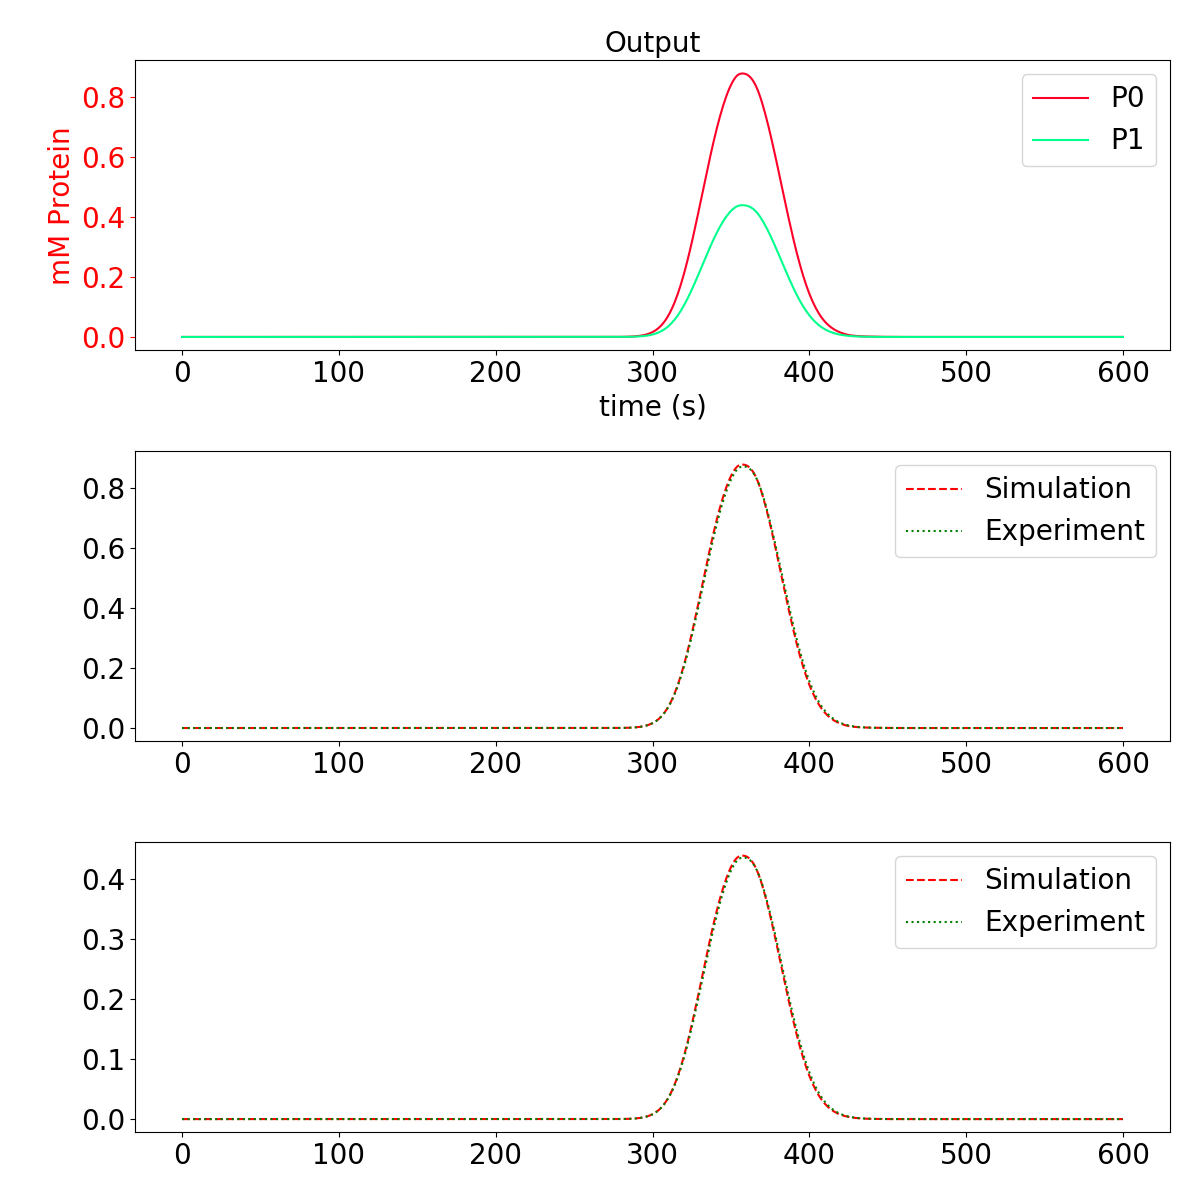

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.93e-07  true_value = 2.00e-07 error: 3.6%
COL_POROSITY Comp:-1 Bound:-1 = 3.69e-01  true_value = 3.70e-01 error: 0.17%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.93e-07  true_value = 2.00e-07 error: 3.6%
COL_POROSITY Comp:-1 Bound:-1 = 3.69e-01  true_value = 3.70e-01 error: 0.17%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.93e-07  true_value = 2.00e-07 error: 3.6%
COL_POROSITY Comp:-1 Bound:-1 = 3.69e-01  true_value = 3.70e-01 error: 0.17%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 1.93e-07  true_value = 2.00e-07 error: 3.6%
COL_POROSITY Comp:-1 Bound:-1 = 3.69e-01  true_value = 3.70e-01 error: 0.17%




In [19]:
true_values2 = numpy.array([example2.root.input.model.unit_001.col_dispersion, 
                           example2.root.input.model.unit_001.col_porosity])
    
sim_comps = run_match(match2,
                    match_file2,
                    true_values2,
                    delete=True)

# Fractionation

Fractionation is when you collect a series of samples from the outlet and measure the concentration of each component. Usually there are 5-10 samples avaiable and a summation UV signal. These are some of the most complex systems to fit.

We will fractionate the multiple components example and fit to the summation UV signal and fractionation data.

The first step is to take our existing multiple component simulation that we just used to create a sum signal and fractionation data. No changes will be made to the simulation, we just need to read the data again.

The fraction graph generated uses lines to join points but they are not actualy continuous. Based on experience these graphs are much harder to follow with the eye if you don't have lines connecting the data points.

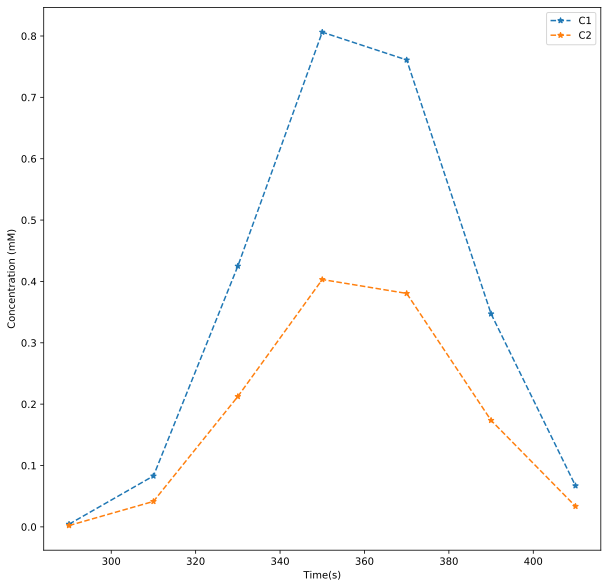

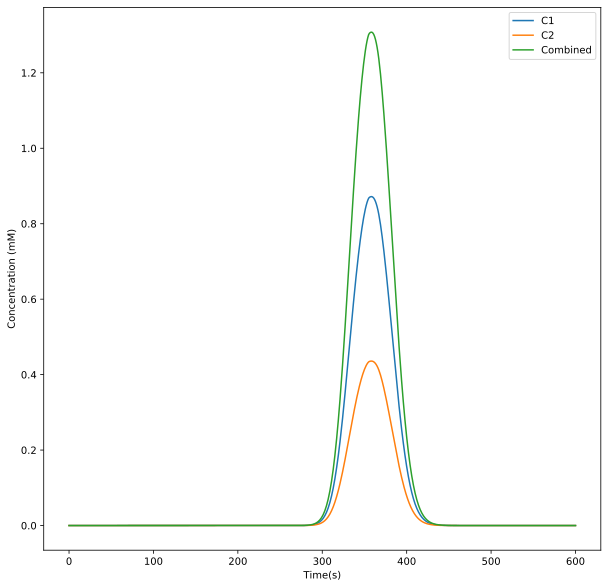

In [22]:
example_dir_3 = lesson_7 / "example_2"
example_dir_3.mkdir(exist_ok = True)

example3 = Cadet()

example3.filename = (example_dir_2 / 'example.h5').as_posix()

example3.load()

example3.filename = (example_dir_3 / 'example.h5').as_posix()

example3.save()


times = example3.root.output.solution.solution_times
values1 = example3.root.output.solution.unit_002.solution_outlet_comp_000
values2 = example3.root.output.solution.unit_002.solution_outlet_comp_001

start_seq = [280, 300, 320, 340, 360, 380, 400]
stop_seq = [300, 320, 340, 360, 380, 400, 420]

min_seq = (numpy.array(start_seq) + numpy.array(stop_seq))/2.0


frac1 = fractionate(start_seq, stop_seq, times, values1)
frac2 = fractionate(start_seq, stop_seq, times, values2)

plt.figure(figsize=[10,10])
plt.plot(min_seq, frac1, '--*', label='C1')
plt.plot(min_seq, frac2, '--*', label='C2')
plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('Concentration (mM)')
plt.show()

df = pandas.DataFrame.from_dict({'Start':start_seq, 'Stop':stop_seq, '0':frac1, '1':frac2})
df.to_csv((example_dir_3 / 'example_fractions.csv').as_posix(), columns=('Start', 'Stop', '0', '1'), index=False)


#plot the simulation
plt.figure(figsize=[10,10])
plt.plot(times, values1, label='C1')
plt.plot(times, values2, label='C2')
plt.plot(times, values1 + values2, label='Combined')
plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('Concentration (mM)')
plt.show()

#write the chromatogram data out to a csv file
data = pandas.DataFrame([times, values1+values2]).transpose()
data.to_csv((example_dir_3 / 'example_combined.csv').as_posix(), index=False, header=False)

## Create a configuration file
There are only a few changes that need to be made to the file to deal with fractionation.

Since we are dealing with the sum signal we need to compare that with the sum of components in our simulation. With CADETMatch you can make isotherm a list and the software will add up all the values in the list. In this case we are adding up component 0 and component 1 with

```python
feature1.isotherm = ["/output/solution/unit_002/SOLUTION_OUTLET_COMP_000", "/output/solution/unit_002/SOLUTION_OUTLET_COMP_001"]
```

The next thing is to create a fractionation setup which looks like

```python
feature = Dict()
feature.name = "Frac"
feature.type = 'fractionationSlide'
feature.fraction_csv = "example_fractions.csv"
feature.unit_name = 'unit_002'
```

or in json it looks like

```json
{
    "name": "Frac",
    "type": 'fractionationSlide',
    "fraction_csv": "example_fractions.csv",
    "unit_name": 'unit_002'
}
```

fraction_csv needs to be the path to the csv file that has fractionation data
unit_name needs to be the name of the unit operation we are trying to fractionate in the system.

In [23]:
match3 = Dict(match0.copy())
match3.CADETPath = cadet_path.as_posix()
match3.baseDir = example_dir_3.as_posix()
match3.resultsDir = 'fit_nsga3_frac'

experiment1 = Dict()
experiment1.csv = "example_c1.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"
experiment1.timeout = 30.0

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'Shape'
feature1.isotherm = ["/output/solution/unit_002/SOLUTION_OUTLET_COMP_000", "/output/solution/unit_002/SOLUTION_OUTLET_COMP_001"]
feature1.csv = "example_combined.csv"

feature2 = Dict()
feature2.name = "Frac"
feature2.type = 'fractionationSlide'
feature2.fraction_csv = "example_fractions.csv"
feature2.unit_name = 'unit_002'

experiment1.features = [feature1, feature2]

match3.experiments = [experiment1,]

match_file3 = example_dir_3 / 'example_nsga3_fractionation.json'

with (match_file3).open('w') as json_file:
    json.dump(match3.to_dict(), json_file, indent='\t')

## Run parameter estimation
Fractionation is a hard problem and it can take significantly longer to fit than if full chromatograms are available. There is less data available and so it is harder to tell if an answer is better or worse.

Your results are located at C:/Users/kosh_000/CADET/lessons/lesson_7/example_2/fit_nsga3_frac 


[2019-10-16 16:33:00,586] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-16 16:33:00,586] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-16 16:33:00,586] launcher  INFO    Worker distribution: 

[2019-10-16 16:33:00,586] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-16 16:33:03,531] util      (b'127.0.0.1:55620') INFO    example.h5 abstol=4.03e-05  reltol=0.0001

[2019-10-16 16:33:04,045] match     (b'127.0.0.1:55620') INFO    simulation took 0.5145728588104248

[2019-10-16 16:33:04,836] gradFD    (b'127.0.0.1:55620') INFO    grad simulation took 0.7560300827026367

[2019-10-16 16:33:04,837] gradFD    (b'127.0.0.1:55620') INFO    grad C:/Users/kosh_000/CADET/lessons/lesson_7/example_2/fit_nsga3_frac/misc/template_main_grad.h5 abstol=4.03e-09 

,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Similarity,main_Pulse_Value,main_Pulse_Time,main_Pulse_Derivative_Similarity,...,main_Frac_Component_0_Similarity,main_Frac_Component_0_Time,main_Frac_Component_0_Value,main_Frac_Component_1_Similarity,main_Frac_Component_1_Time,main_Frac_Component_1_Value,Product Root Score,Min Score,Mean Score,SSE
1,Wed Oct 16 16:33:38 2019,90d71fb328869fd685bf5929edfd3ed0,EVO,NaN,1.944142e-07,0.373571,1.0,0.999533,0.998214,0.999997,...,1.0,0.997327,0.999524,1.0,0.99733,0.999477,0.999174,0.997327,0.999174,0.731389


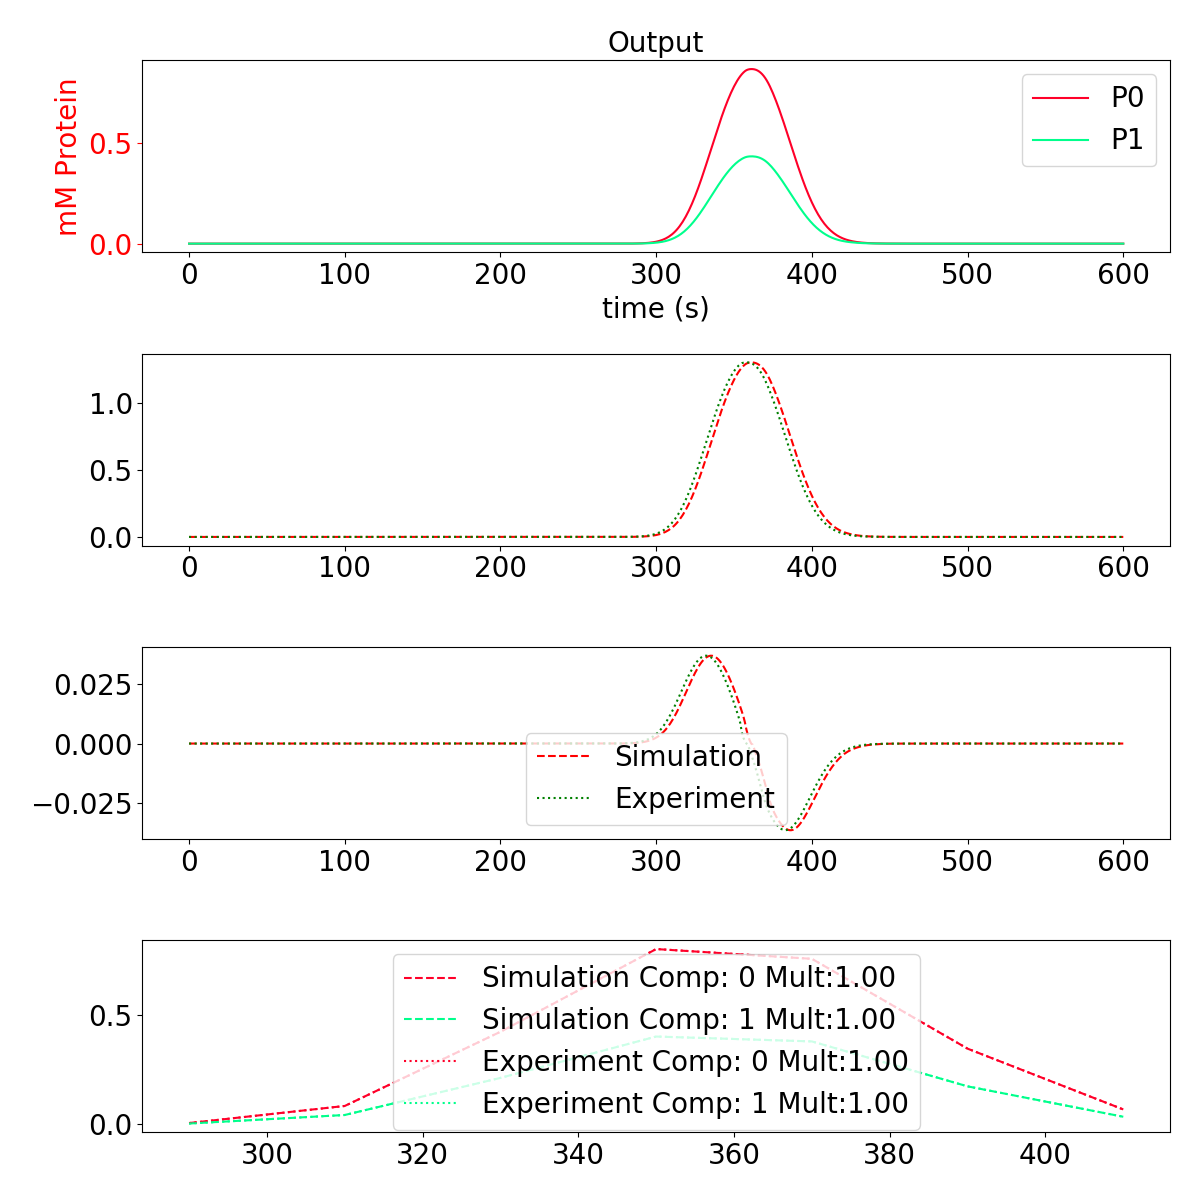

Best item 5af07bb04c067f158cb9d5452736279d for meta score(s) Min Score


,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Similarity,main_Pulse_Value,main_Pulse_Time,main_Pulse_Derivative_Similarity,...,main_Frac_Component_0_Similarity,main_Frac_Component_0_Time,main_Frac_Component_0_Value,main_Frac_Component_1_Similarity,main_Frac_Component_1_Time,main_Frac_Component_1_Value,Product Root Score,Min Score,Mean Score,SSE
5,Wed Oct 16 16:33:56 2019,5af07bb04c067f158cb9d5452736279d,EVO,NaN,1.944893e-07,0.373536,1.0,0.999664,0.998235,0.999993,...,1.0,0.997359,0.999472,1.0,0.997363,0.999406,0.999002,0.997359,0.999002,0.714098


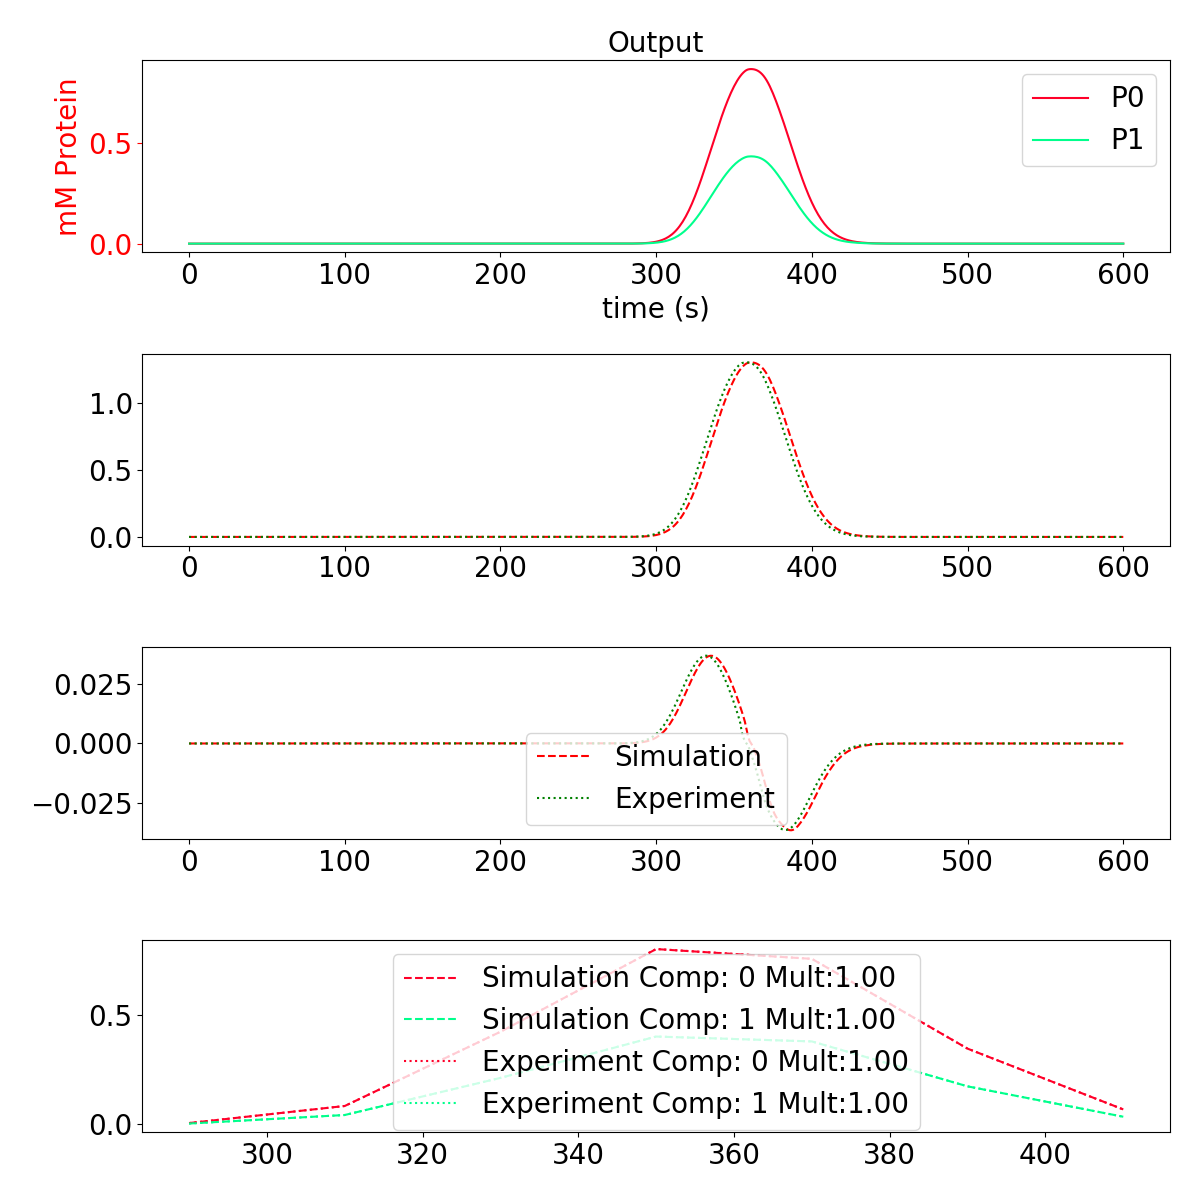

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.94e-07  true_value = 2.00e-07 error: 2.9%
COL_POROSITY Comp:-1 Bound:-1 = 3.74e-01  true_value = 3.70e-01 error: 0.96%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.94e-07  true_value = 2.00e-07 error: 2.8%
COL_POROSITY Comp:-1 Bound:-1 = 3.74e-01  true_value = 3.70e-01 error: 0.95%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.94e-07  true_value = 2.00e-07 error: 2.9%
COL_POROSITY Comp:-1 Bound:-1 = 3.74e-01  true_value = 3.70e-01 error: 0.96%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 1.94e-07  true_value = 2.00e-07 error: 2.9%
COL_POROSITY Comp:-1 Bound:-1 = 3.74e-01  true_value = 3.70e-01 error: 0.96%




In [24]:
true_values3 = numpy.array([example3.root.input.model.unit_001.col_dispersion, 
                           example3.root.input.model.unit_001.col_porosity])
    
sim_frac = run_match(match3,
                    match_file3,
                    true_values3,
                    delete=True)

# Estimating per component parameters
One of the final steps is estimating parameters that are different for each component. For this test we will take the 2-component SMA example from Lesson 3 and estimate nu for each component. In practice you can estimate any number of variables although as you estimate more variables you also need more data and more computation time which rises very rapidly. 

## Copy the simulation from Lesson 3 and make sure it runs correctly

CompletedProcess(args=['C:/Users/kosh_000/CADET/cadet/bin/cadet-cli.exe', 'C:/Users/kosh_000/CADET/lessons/lesson_7/example_2/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


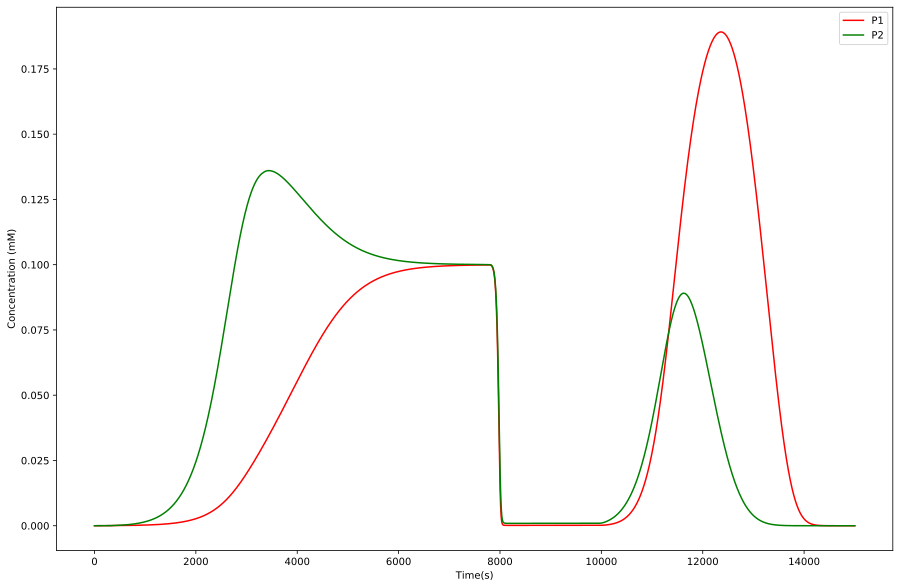

In [25]:
example_dir_4 = lesson_7 / "example_2"
example_dir_4.mkdir(exist_ok = True)

example4 = Cadet()

#give a filename for where the simulation should be saved
example4.filename = (lesson_3 / "example_1" / 'example.h5').as_posix()

example4.load()

example4.filename = (example_dir_4 / 'example.h5').as_posix()

#save the simulation
example4.save()

#run the simulation
data = example4.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    example4.load()
    
    #plot the simulation
    plt.figure(figsize=[15,10])
    plt.plot(example4.root.output.solution.solution_times,
        example4.root.output.solution.unit_002.solution_outlet_comp_001, 'r', label="P1")
    plt.plot(example4.root.output.solution.solution_times,
        example4.root.output.solution.unit_002.solution_outlet_comp_002, 'g', label="P2")
    plt.legend()
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([example4.root.output.solution.solution_times,
                        example4.root.output.solution.unit_002.solution_outlet_comp_001]).transpose()
    data.to_csv((example_dir_4 / 'example_c1.csv').as_posix(), index=False, header=False)
    
    data = pandas.DataFrame([example4.root.output.solution.solution_times,
                        example4.root.output.solution.unit_002.solution_outlet_comp_002]).transpose()
    data.to_csv((example_dir_4 / 'example_c2.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Create configuration file
Now that we are estimating parameters that are per component we need to make a couple simple changes to the parameters field.

The component field is the component number we need to change. In this case 0 is salt, 1 is protein 1 and 2 is protein 2. We want to estimate NU for protein 1 and 2. 

The bound field should be set to 0 since we want the first bound state. Some isotherms have multiple bound states.

```python
parameter = Dict()
parameter.transform = 'norm'
parameter.component = 1
parameter.bound = 0
parameter.location = "/input/model/unit_001/adsorption/SMA_NU"
parameter.min = 2
parameter.max = 15
```

In JSON it looks like

```json
{
    'transform': 'norm',
    'component': 1,
    'bound': 0,
    'location': "/input/model/unit_001/adsorption/SMA_NU",
    'min': 2,
    'max':15
}
```

In [26]:
match4 = Dict()
match4.CADETPath = cadet_path.as_posix()
match4.baseDir = example_dir_4.as_posix()
match4.resultsDir = 'fit_nsga3'
match4.csv = 'fit_results.csv'
match4.checkpointFile = "check"
match4.stopAverage = 1
match4.stopBest = 1
match4.gradCheck = 1
match4.gradVector = 1
match4.searchMethod = 'NSGA3'
match4.mutationRate = 1.0
match4.crossoverRate = 1.0
match4.generations = 1000
match4.population = 12
match4.minPopulation = 12
match4.maxPopulation = 12
match4.finalGradRefinement = 1
match4.stallGenerations = 10

parameter1 = Dict()
parameter1.transform = 'norm'
parameter1.component = 1
parameter1.bound = 0
parameter1.location = "/input/model/unit_001/adsorption/SMA_NU"
parameter1.min = 2
parameter1.max = 15

parameter2 = Dict()
parameter2.transform = 'norm'
parameter2.component = 2
parameter2.bound = 0
parameter2.location = "/input/model/unit_001/adsorption/SMA_NU"
parameter2.min = 2
parameter2.max = 15

match4.parameters = [parameter1, parameter2]

experiment1 = Dict()
experiment1.csv = "example_c1.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"
experiment1.timeout = 30.0

feature1 = Dict()
feature1.name = "C1"
feature1.type = 'Shape'
feature1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_001"
feature1.csv = "example_c1.csv"

feature2 = Dict()
feature2.name = "C2"
feature2.type = 'Shape'
feature2.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_002"
feature2.csv = "example_c2.csv"

experiment1.features = [feature1, feature2]

match4.experiments = [experiment1,]

match_file4 = example_dir_4 / 'example_nsga3.json'

with (match_file4).open('w') as json_file:
    json.dump(match4.to_dict(), json_file, indent='\t')

## Run parameter estimation

Your results are located at C:/Users/kosh_000/CADET/lessons/lesson_7/example_2/fit_nsga3 


[2019-10-16 16:35:40,145] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-16 16:35:40,145] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-16 16:35:40,145] launcher  INFO    Worker distribution: 

[2019-10-16 16:35:40,145] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-16 16:35:43,740] util      (b'127.0.0.1:57893') INFO    example.h5 abstol=1.36e-05  reltol=0.0001

[2019-10-16 16:35:45,984] match     (b'127.0.0.1:57893') INFO    simulation took 2.2429959774017334

[2019-10-16 16:36:05,169] gradFD    (b'127.0.0.1:57893') INFO    grad simulation took 19.13593077659607

[2019-10-16 16:36:05,169] gradFD    (b'127.0.0.1:57893') INFO    grad C:/Users/kosh_000/CADET/lessons/lesson_7/example_2/fit_nsga3/misc/template_main_grad.h5 abstol=1.36e-09  reltol=1e-

[2019-10-16 16:56:37,028] util      (b'127.0.0.1:57893') INFO    Generation: 35 	Population: 24 	Average Score: 0.969 	Best: 0.999 	Minimum Score: 0.773 	Best: 0.998 	Product Score: 0.954 	Best: 0.999

[2019-10-16 16:57:04,670] util      (b'127.0.0.1:57893') INFO    Generation: 36 	Population: 24 	Average Score: 0.968 	Best: 0.999 	Minimum Score: 0.771 	Best: 0.998 	Product Score: 0.954 	Best: 0.999

[2019-10-16 16:57:04,781] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-16 16:57:04,781] launcher  INFO    Deploying 4 worker(s) over 1 host(s).

[2019-10-16 16:57:04,781] launcher  INFO    Worker distribution: 

[2019-10-16 16:57:04,781] launcher  INFO       127.0.0.1:	3 + origin

[2019-10-16 16:57:07,052] generate_graphs (b'127.0.0.1:53686') INFO    graphing directory C:\Users\kosh_000\CADET\lessons\lesson_7\example_2

[2019-10-16 16:57:09,207] launcher  (127.0.0.1:

,Time,Name,Method,Condition Number,SMA_NU Comp:1 Bound:0,SMA_NU Comp:2 Bound:0,main_C1_Similarity,main_C1_Value,main_C1_Time,main_C1_Derivative_Similarity,...,main_C2_Similarity,main_C2_Value,main_C2_Time,main_C2_Derivative_Similarity,main_C2_Der_High_Value,main_C2_Der_Low_Value,Product Root Score,Min Score,Mean Score,SSE
0,Wed Oct 16 16:50:09 2019,bfafa130e4e82aa012b9757c112fe7cc,EVO,NaN,6.984235,4.987375,0.999998,0.999076,0.999866,0.999992,...,0.999994,0.998826,0.998343,0.99991,0.999489,0.999373,0.999365,0.998073,0.999365,0.000784


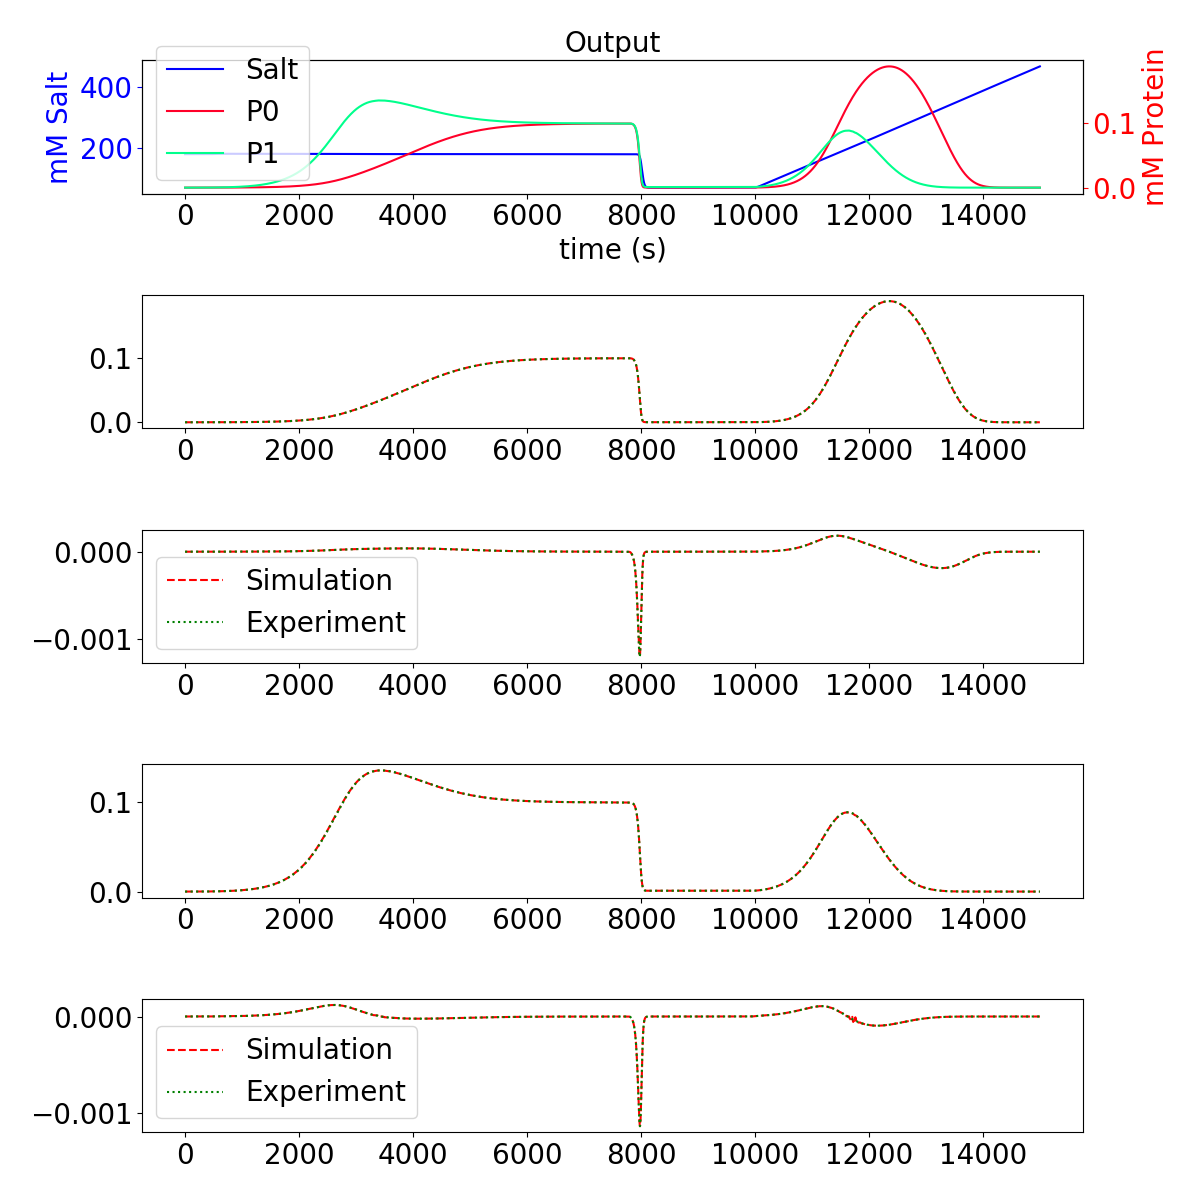

Method: Product Root Score
SMA_NU Comp:1 Bound:0 = 6.98e+00  true_value = 7.00e+00 error: 0.23%
SMA_NU Comp:2 Bound:0 = 4.99e+00  true_value = 5.00e+00 error: 0.25%


Method: Min Score
SMA_NU Comp:1 Bound:0 = 6.98e+00  true_value = 7.00e+00 error: 0.23%
SMA_NU Comp:2 Bound:0 = 4.99e+00  true_value = 5.00e+00 error: 0.25%


Method: Mean Score
SMA_NU Comp:1 Bound:0 = 6.98e+00  true_value = 7.00e+00 error: 0.23%
SMA_NU Comp:2 Bound:0 = 4.99e+00  true_value = 5.00e+00 error: 0.25%


Method: SSE
SMA_NU Comp:1 Bound:0 = 6.98e+00  true_value = 7.00e+00 error: 0.23%
SMA_NU Comp:2 Bound:0 = 4.99e+00  true_value = 5.00e+00 error: 0.25%




In [27]:
true_values4 = numpy.array([example4.root.input.model.unit_001.adsorption.sma_nu[1], 
                           example4.root.input.model.unit_001.adsorption.sma_nu[2]])
    
sim_parm = run_match(match4,
                    match_file4,
                    true_values4,
                    delete=True)